# 07.02 Full Road Trip

Let's move forward: can we estimate the speed at each point on a longer strip of a road?
For example, some 30km of a road with turns and inclines.

![Formula One](fe-formula-one.svg)

<div style="text-align:right;"><sup>fe-formula-one.svg</sup></div>

We import the common suspects and make a short simulation of a road trip.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

For our simulation it is interesting to note that most problems in the real world are not linear,
they are either exponential or periodic.  Why?  Something, something, complexity theory.
Anyway, speed on a road is a periodic problem, one speeds up and down in response
to the shape of the road he drives on.

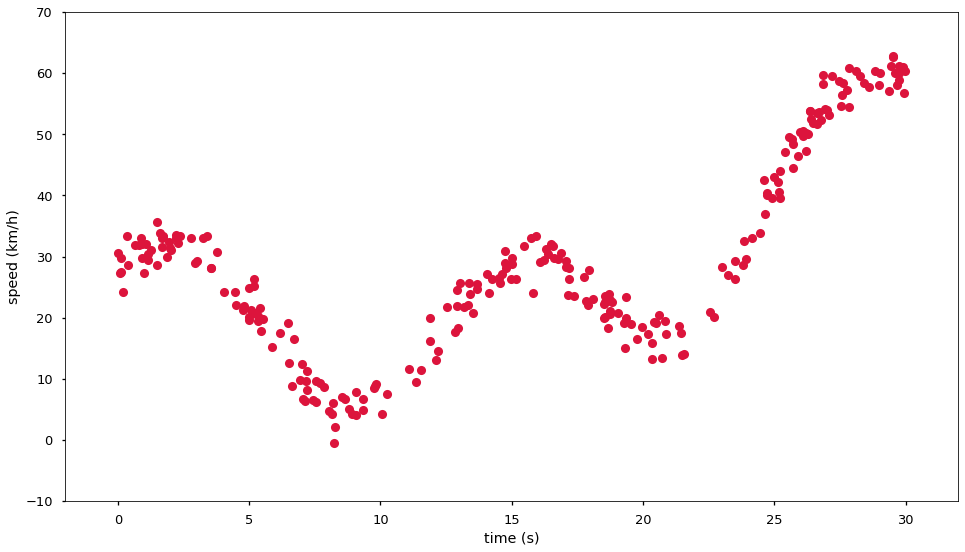

In [2]:
t = 30*np.random.rand(256)
spd = 13*np.sin(t/2) + 3.7*np.cos(t/2+7) + 3*t + 0.1*(t-10)**2 - 3*(t-3) + 7 + 2.3*np.random.randn(*t.shape)
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(t, spd, 'o', color='crimson')
ax.set(xlabel='time (s)', ylabel='speed (km/h)', xlim=(-2, 32), ylim=(-10, 70));

It is pretty difficult to figure out what polynomial degree we need for this fit.
But let's try a guess, degree 5.

For the time being we will not worry about a test set or cross validation,
we will just explore the data.
Once we know something about the problem we will come back and
perform proper model evaluation.

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

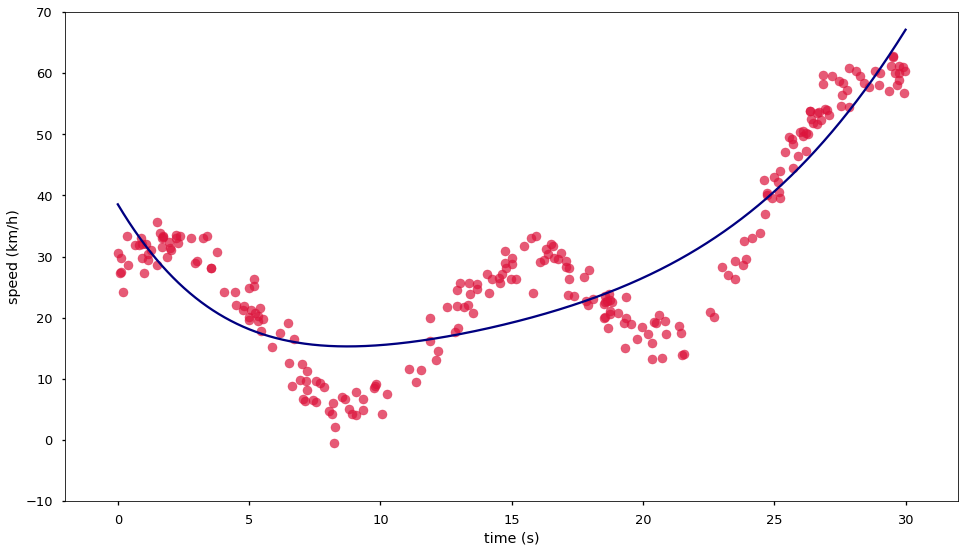

In [3]:
model = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
model.fit(t[:, np.newaxis], spd[:, np.newaxis])
xfit = np.linspace(0, 30, 3000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set(xlabel='time (s)', ylabel='speed (km/h)', xlim=(-2, 32), ylim=(-10, 70))
model

Ouch, that went pretty badly.  This is a case where out model **underfits** the data,
i.e. our model has not enough complexity to model the complexity we see.
We can also say that our model has too much **bias** about how the data looks.

Let us try with a big degree, e.g. 100.

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=100, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

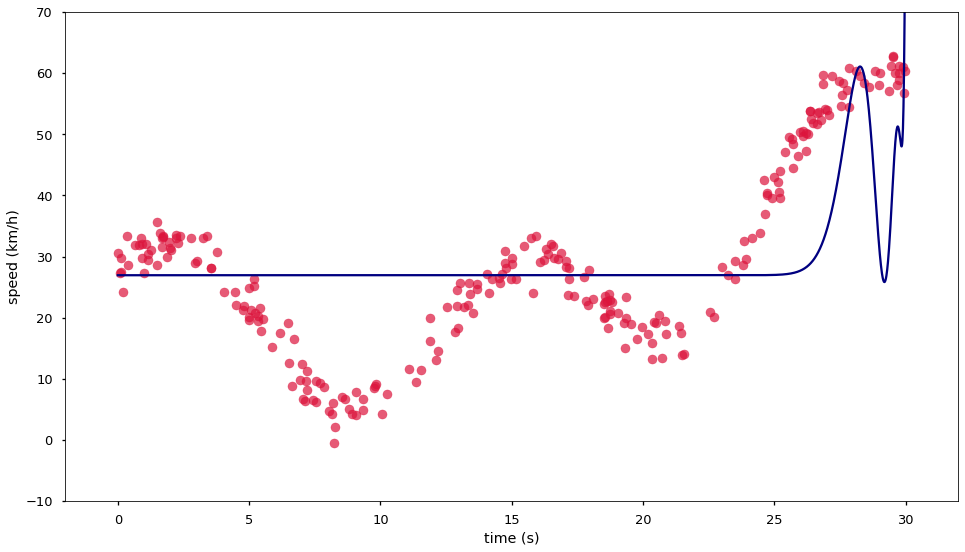

In [4]:
model = make_pipeline(PolynomialFeatures(degree=100), LinearRegression())
model.fit(t[:, np.newaxis], spd[:, np.newaxis])
xfit = np.linspace(0, 30, 3000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set(xlabel='time (s)', ylabel='speed (km/h)', xlim=(-2, 32), ylim=(-10, 70))
model

That ain't good either.
On the left hand side we passed the point where we can bend
the polynomial and our parameters mess with each other.
On the right hand side the polynomial **overfits** the data;
or we say that the model has too much **variance**.
There are two different examples of *overfitting* on the graph.

On the *right* we see a classical case where the function has
too much variance.
In such a case the parameters will attempt to move the function
directly through every single point,
and fail to generate a reasonable function across the points
in pretty much all cases.

On the *left* the linear regression did attempt to find good parameters
for several degrees but every time it increased a parameter to, say,
$t^{36}$ in order to make the function go up in a specific place it
did affect the other places around the function.
In turn the function attempted to change the parameter for, say,
$t^{47}$ in order to counter the problems generated by the previous
parameter increase but this again backfired by changing the function
value in other places.
The issue happens because linear regression assumes that the is no
relationship between the different variables to which the parameters
are multiplied.
But here $t^{36}$ is very related to $t^{47}$, and also to $t^{63}$,
and to pretty much every other value from polynomial features.

There is more than one way to solve this problem.
Let's see one way: model selection.

## Bias versus Variance - Model Selection

To solve the right hand side problem we need to tune of *hyperparameter*,
the degree of our polynomial.
And then we hope that the left hand side get solved due to a smaller
number of parameters.
In the case where the left hand side does not get solved then we need to
look into regularization - which we will see next.

Until now we have been guessing and doing this by hand
but trying all values between $5$ and $100$
by hand does not seem like a good way of spending an afternoon.
Instead `sklearn` can automate this for us.

We will train a model for every degree between $5$ and $100$ and evaluate,
by cross-validation, which model performs better.
`sklearn` provides us with a grid search algorithm,
which will perform the training and cross-validating of our model
for all hyperparameter values given to it.
The `GridSearchCV` is another `sklearn` object
that takes `sklearn` objects and gives out a similar interface.
When one performs `fit` on a grid search object,
it will train models with all possible combinations given
in the grid of *hyperparameters*.
It then performs cross validation on every model
and chooses the model which has the best mean cross validation score.
The cross validation argument we use `cv=5` is the `sklearn`'s default.
It performs $5$ fold splits *without shuffling* the data,
in order to perform a shuffle one can use a `KFold`
in the same fashion as with `cross_val_score`.

Here we define the grid search to train $95$ linear regression models,
each with a different value for the degree of the polynomial features
given to the regression itself.
We give into the grid search a model that itself is a pipeline of models.
That is no issue for the grid search,
note how can we specify the element of the pipeline to which
the hyperparameter range is to be applied by using a double underscore.
We use `polynomialfeatures__degree` to refer to the `degree=`
hyperparameter of the `PolynomialFeatures` object,
inside the pipeline.
And the pipeline itself allows for more shortcuts
to the contained objects with the `named_steps` attribute.

We are starting to automate hyperparameter selection.
Once a best set of hyperparameters is identified by the grid search,
it trains a model with these hyperparameter values and all the data.
This trained model is then available under `best_estimator_`,
and the cross validation mean score that allowed the selection
of this model as best under `best_score_`

(Pipeline(memory=None,
          steps=[('polynomialfeatures',
                  PolynomialFeatures(degree=10, include_bias=True,
                                     interaction_only=False, order='C')),
                 ('linearregression',
                  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                   normalize=False))],
          verbose=False),
 array([28.07079204]),
 array([[ 0.00000000e+00,  5.63557642e+00, -2.98208857e+00,
          1.08366384e+00, -3.23484837e-01,  5.24801162e-02,
         -4.64249930e-03,  2.34704276e-04, -6.79413019e-06,
          1.04914400e-07, -6.70557831e-10]]))

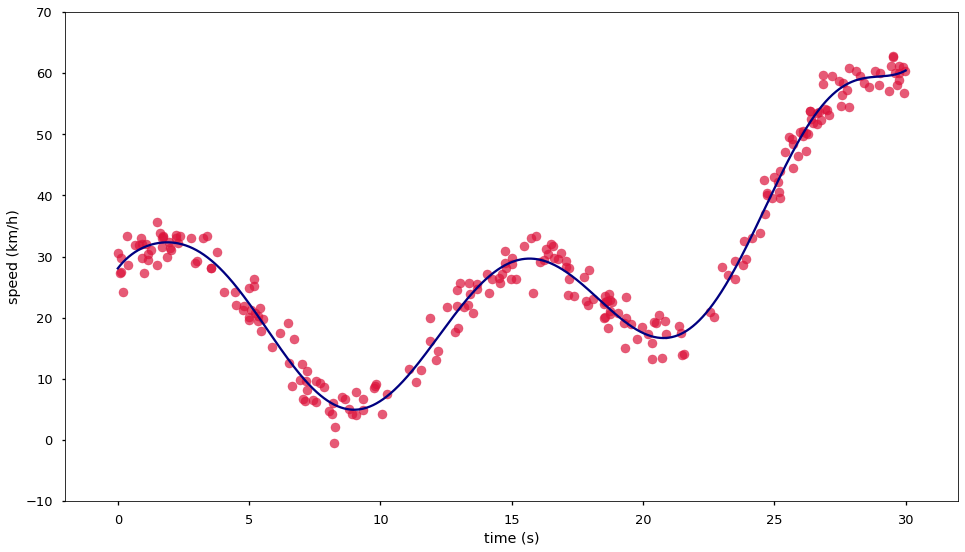

In [5]:
from sklearn.model_selection import GridSearchCV

model = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
grid = GridSearchCV(model,
                    {'polynomialfeatures__degree': list(range(5, 101))},
                    cv=5)
grid.fit(t[:, np.newaxis], spd[:, np.newaxis])
best = grid.best_estimator_

xfit = np.linspace(0, 30, 3000)
yfit = best.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set(xlabel='time (s)', ylabel='speed (km/h)', xlim=(-2, 32), ylim=(-10, 70))
best, best.named_steps.linearregression.intercept_, best.named_steps.linearregression.coef_

And we should have a look at the `R2` of the best estimator we have built.

In [6]:
grid.best_score_

0.9766121925237712

Often simple *hyperparameter* tuning is enough to solve even complex problems.
Yet, the problem we saw on the left hand side was a problem of dependence between dimensions,
and sometimes it cannot be easily solved.
We shall look at more techniques.

## Extra References

- [Underfitting and Overfitting - SciKit Learn Documentation][1]

[1]: https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html "Underfitting and Overfitting"